## **Training a deep learning model (Clasical solution)**

```javascript
Since we made our dataset private on Hugging Face during phase 2, we need to log in to access it.
```

In [1]:
!huggingface-cli login --token ""

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## **Imports and instalations**

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 921.7 kB/s eta 0:00:000:00:01


In [3]:
from transformers import AutoImageProcessor, TrainingArguments, Trainer
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from datasets import load_dataset
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig, AutoImageProcessor
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import AutoModelForImageClassification

import torch
import torch.nn as nn
import pandas as pd
import numpy as np

2024-08-05 22:11:55.059334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 22:11:55.059442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 22:11:55.164573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Loading the dataset**

```java
We can easily access the image dataset using this method:
```

In [18]:
dataset = load_dataset("LaLegumbreArtificial/womanium-balance")

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [5]:
label2id, id2label

({'GOOD': '0', 'DAMAGE': '1'}, {'0': 'GOOD', '1': 'DAMAGE'})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 6000
    })
})

## **Preprocessing of the data**


```java
In the next two cells, we have implemented the necessary image preprocessing steps to prepare the data for training a classical model. This will allow us to compare the results with those of other approaches.
```

In [7]:
model_checkpoint = "microsoft/beit-base-patch16-224-pt22k-ft22k"
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)


normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

In [8]:
dataset = dataset.with_transform(transforms)

```java
In the final result, each image is normalized, cropped, and converted into a tensor, making it ready for input into the model.
```

In [9]:
dataset["train"][0]["pixel_values"]

tensor([[[-0.6000, -0.5843, -0.5686,  ..., -0.5373, -0.5373, -0.5373],
         [-0.5843, -0.5686, -0.5529,  ..., -0.5373, -0.5373, -0.5451],
         [-0.5529, -0.5529, -0.5451,  ..., -0.5529, -0.5529, -0.5373],
         ...,
         [-0.5843, -0.5608, -0.5373,  ..., -0.3961, -0.4118, -0.3882],
         [-0.5765, -0.5608, -0.5451,  ..., -0.4039, -0.4039, -0.3725],
         [-0.5765, -0.5608, -0.5451,  ..., -0.4039, -0.3961, -0.3725]],

        [[-0.6000, -0.5843, -0.5686,  ..., -0.5373, -0.5373, -0.5373],
         [-0.5843, -0.5686, -0.5529,  ..., -0.5373, -0.5373, -0.5451],
         [-0.5529, -0.5529, -0.5451,  ..., -0.5529, -0.5529, -0.5373],
         ...,
         [-0.5843, -0.5608, -0.5373,  ..., -0.3961, -0.4118, -0.3882],
         [-0.5765, -0.5608, -0.5451,  ..., -0.4039, -0.4039, -0.3725],
         [-0.5765, -0.5608, -0.5451,  ..., -0.4039, -0.3961, -0.3725]],

        [[-0.6000, -0.5843, -0.5686,  ..., -0.5373, -0.5373, -0.5373],
         [-0.5843, -0.5686, -0.5529,  ..., -0

## **Evaluation metrics**

```java
In this case, we chose accuracy as the primary metric. Given that the dataset is balanced between the two classes, additional metrics are not necessary at this time.
```

In [10]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [11]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

## **Model creation**

```java
In this cell, we created the model using the Hugging Face interface. The parameters include the number of labels for training. The id2label and label2id mappings are provided so that the model can give predictions with label names instead of just probabilities.
```

In [12]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Training and parameters**

```java
Here we defined the hyperparameters used for the model, such as the learning rate, optimizer settings, number of epochs, and batch sizes for both training and evaluation:
```

In [ ]:
training_args = TrainingArguments(
    output_dir=f"Fraunhofer_Classical",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    do_train=True,
    do_eval=True,
    push_to_hub=True,
)

```java
Here we train the model and evaluate it on the test set for validation, and we got 99% on the test set
```

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
0,0.060800,0.087856,0.970000
2,0.043600,0.035060,0.987333
4,0.023600,0.023507,0.990667


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=545, training_loss=0.07557219548509755, metrics={'train_runtime': 2831.1456, 'train_samples_per_second': 24.725, 'train_steps_per_second': 0.193, 'total_flos': 5.39857330857286e+18, 'train_loss': 0.07557219548509755, 'epoch': 4.9771689497716896})

In [15]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/LaLegumbreArtificial/Fraunhofer_Classical/commit/88b102a3d02dca9797b9426414c7c600f2fd9de5', commit_message='End of training', commit_description='', oid='88b102a3d02dca9797b9426414c7c600f2fd9de5', pr_url=None, pr_revision=None, pr_num=None)

## **Example of a prediction**

```java
Here is an example of a prediction to illustrate how we can use the model. We will use this example to evaluate the model’s performance at the end.
```

In [16]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="LaLegumbreArtificial/Fraunhofer_Classical")

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [19]:
pipe(dataset["train"][4]["image"])

[{'label': 'DAMAGE', 'score': 0.9999951124191284},
 {'label': 'GOOD', 'score': 4.883512701781001e-06}]

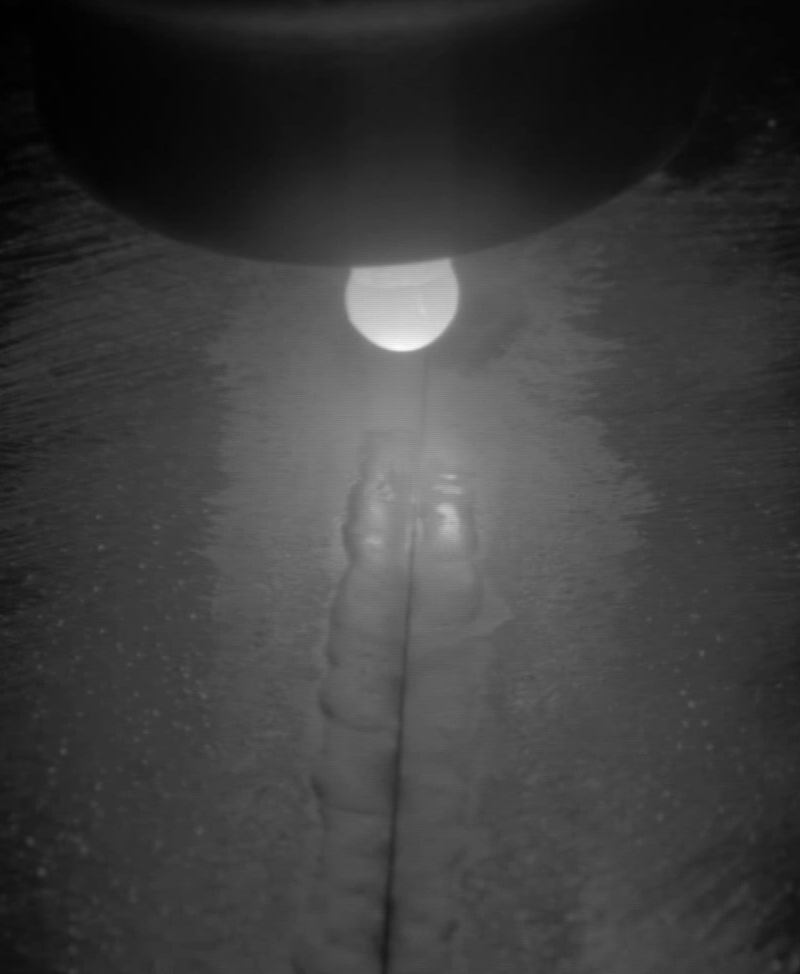

In [20]:
dataset["train"][4]["image"]